In this notebook, we explored the following things:
- **Text Data Preprocessing (NLTK, SpaCy)**
    - text cleaning
    - tokenization 
    - lemmatization
    - stopwords extracting and removing
    - keywords extraction with frequency
    
    
- **Word2vec Embedding (GenSim)**
    - used pretrained word2vec matrix from [here](https://github.com/alexandres/lexvec#pre-trained-vectors)
    - word space dimension: 300
    
    
- **Unsupervised Classification**
    - take the sector which has the highest weighted average cos similarity with common keywords in each file
    - accuracy: 0.474 on 955 predictions
    
    
- **Supervised Classification (Sklearn)**
    - applied PCA to reduce the word dimension to 20
    - used the same classifers in classification/supervised_sector_classification_3
    - testing accuracies are pretty comparable and slightly higher

In [1]:
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('word_bank_project_description.csv', index_col=0)

## Text Data Preprocessing

In [3]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
import spacy
spacy_en = spacy.load('en_core_web_sm')
from nltk.tokenize import SpaceTokenizer
from collections import Counter

from gensim.parsing.preprocessing import STOPWORDS
my_stop_words = STOPWORDS.union(set(['project', '']))

# basic text preprocessing
from nlpretext.basic.preprocess import normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, lower_text, replace_numbers
from nlpretext import Preprocessor

preprocessor = Preprocessor()
functions = [remove_punct, remove_eol_characters, lower_text]
for func in functions:
    preprocessor.pipe(func)
preprocessor.pipe(remove_stopwords, args = {'lang':'en'})
preprocessor.pipe(replace_numbers, args = {'replace_with':''})
preprocessor.pipe(normalize_whitespace)

# token preprocessing
from nlpretext.token.preprocess import remove_smallwords, remove_tokens_with_nonletters
token_clean = Preprocessor()
token_clean.pipe(remove_smallwords, args = {'smallwords_threshold': 2})
token_clean.pipe(remove_tokens_with_nonletters)


tk = SpaceTokenizer()
def tokenize(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    text = preprocessor.run(text)
    tokens = [tok.text for tok in spacy_en.tokenizer(text)]
    tokens = token_clean.run(tokens)
    return tokens

def get_common(doc,k = 100, stop_words = my_stop_words):
    """
    Take lemmatization and get top k common words
    """
    try:
        counter = Counter([lemmatizer.lemmatize(tok) for tok in tokenize(doc)])
        words = counter.most_common(k)
        words = [word for word in words if word[1] > 1]
        return pd.Series([words, ' '.join([item[0] for item in words])], index = ['common_words_counts', 'common_words'] )
    except:
        return pd.Series(['',''], index = ['common_words_counts', 'common_words'])

In [4]:
get_common(df.loc[0,'project_desc'])

common_words_counts    [(serbia, 5), (part, 5), (project, 4), (rehabi...
common_words           serbia part project rehabilitation thermal mon...
dtype: object

In [5]:
df[['common_words_counts', 'common_words']] = df['project_desc'].apply(lambda x: get_common(x, 100, my_stop_words))

In [6]:
df.head()

,year,month,day,id,name,project_desc,top_common_40,common_words_counts,common_words
0,1991,september,12,558671468103155868,conformed-copy--l3361--kolubara-b-thermal-powe...,SCHEDULE 2\n\n Description ...,serbia rehabilitation thermal monitoring progr...,"[(serbia, 5), (part, 5), (project, 4), (rehabi...",serbia part project rehabilitation thermal mon...
1,2001,may,31,473681468094784501,conformed-copy--l7054--railway-restructuring-p...,SCHEDULE 2\n\nDescription of the Project\n\nTh...,borrower staff program objectives transport se...,"[(program, 5), (project, 4), (borrower, 4), (p...",program project borrower part staff objective ...
2,1991,november,19,892131468028134392,china--beijing-environmental-project-:-loan-34...,NaN,NaN,,
3,2013,may,20,945021468224685176,"official-documents-loan-agreement,-l8236-cn-cl...",SCHEDULE1\n\nProject Description\n\nThe objec...,urban rehabilitation water construction city s...,"[(project, 12), (city, 9), (urban, 7), (system...",project city urban system rehabilitation water...
4,1991,may,7,107521468303622178,conformed-copy--l3230--third-highway-sector-pr...,SCHEDULE 2\n\nDescription of the Project\n\nTh...,maintenance improve highway planning including...,"[(maintenance, 6), (part, 5), (project, 4), (i...",maintenance part project improve highway plann...


### Extract my own stop words

In [7]:
# get common words among all docs
common_words_all = pd.Series(' '.join(df['common_words']).split())
vocabulary = common_words_all.value_counts().reset_index(name = 'count')

upper_threshold = int(len(df) / 5)
print('Words existing in more than ', upper_threshold, ' files: \n')
print(vocabulary[vocabulary['count'] > upper_threshold]['index'].values)

lower_threshold = 2
print('\nWords existing in less than ', lower_threshold, ' files: \n')
print(vocabulary[vocabulary['count'] < lower_threshold]['index'].values)


# collecting low and high frequency words
my_stop_words = set(vocabulary[vocabulary['count'] > upper_threshold]['index'].values).union(set(vocabulary[vocabulary['count'] < lower_threshold]['index'].values))

# remove my_stop_words from vocabulary
vocabulary_set = set(vocabulary['index'].values).difference(my_stop_words)

Words existing in more than  639  files: 

['project' 'part' 'provision' 'borrower' 'management' 'system' 'time'
 'including' 'objective' 'service' 'program' 'development' 'training'
 'carrying' 'support' 'technical' 'capacity' 'implementation'
 'strengthening' 'assistance' 'equipment' 'bank' 'institutional'
 'monitoring' 'financial' 'study' 'good' 'construction' 'improve' 'area'
 'activity' 'sector' 'loan' 'information']

Words existing in less than  2  files: 

['precast' 'familiarize' 'aa' ... 'sapao' 'enim' 'parameter']


In [8]:
print('Number of my_stop_words: ', len(my_stop_words))
print('Number of vocabulary: ', len(vocabulary_set))

Number of my_stop_words:  3780
Number of vocabulary:  3846


In [11]:
#load model and get vectors (takes several minutes)
model = gensim.models.KeyedVectors.load_word2vec_format('lexvec.enwiki+newscrawl.300d.W+C.pos.vectors', binary = False)

In [13]:
# remove words not in the model
words_not_in_model = set()
for word in vocabulary_set:
    if word not in model:
        words_not_in_model.add(word)
my_stop_words = my_stop_words.union(words_not_in_model)
vocabulary_set = vocabulary_set.difference(words_not_in_model)

In [14]:
print('Number of words not in model: ', len(words_not_in_model))
print('Number of my_stop_words: ', len(my_stop_words))
print('Number of vocabulary: ', len(vocabulary_set))

Number of words not in model:  0
Number of my_stop_words:  4095
Number of vocabulary:  3531


### Remove my own stopwords

In [15]:
def remove_my_stopword(x, my_stop_words):
    return [word for word in x if word[0] not in my_stop_words]

df['common_words_counts_no_stopwords'] = df['common_words_counts'].apply(lambda x: remove_my_stopword(x, my_stop_words))

df['common_words'] = df['common_words_counts_no_stopwords'].apply(lambda x: ' '.join([word[0] for word in x]))

### Word Embedding and Document Clustering
We apply the pretrained word2vec matrix from https://github.com/alexandres/lexvec#pre-trained-vectors. 

In [16]:
def get_weighted_vec(words):
    try:
        word_list = [w[0] for w in words]
        word_vecs = model[word_list]
        freq_list = [w[1] for w in words]
        freq_list = np.array(freq_list)
        return list(word_vecs.T @ freq_list / len(freq_list))
    except:
        return 
# get_weighted_vec(df.loc[0, 'common_words_counts_no_stopwords'])

In [17]:
df['doc_vec'] = df['common_words_counts_no_stopwords'].apply(get_weighted_vec)

In [18]:
def ave_cosim(word, words):  
    word_list = [w[0] for w in words]
    freq_list = [w[1] for w in words]
    freq_list = np.array(freq_list)
    similarities = model.cosine_similarities(model[word], model[word_list])
    return np.dot(freq_list, similarities)/sum(freq_list)

In [19]:
sectors = ['Transportation', 'Water/Sanitation/Waste', 'Agriculture',
       'Industry and Trade/Services', 'Education', 'Health',
       'Energy and Extractives', 'Public Admin', 'Financial Sector',
       'Social Protection', 'Info and Communication']

sector_lists = [['transportation'], ['water', 'sanitation', 'waste'], 
                ['agriculture'], ['industry', 'trade', 'services'],
                ['education'], ['health'], ['energy', 'extractive'],
                ['public', 'admin'], ['financial', 'sector'], 
                ['social', 'protection'], ['info', 'communication']]
def get_sector(words):
    try:
        scores = []
        for word in sector_lists:
            score = 0
            for w in word:
                score += ave_cosim(w, words)
            scores.append(score/len(word))
        index = scores.index(max(scores))
        return sectors[index]
    except:
        return None

In [20]:
df['sectors_from_word2vec'] = df['common_words_counts_no_stopwords'].apply(get_sector)

In [21]:
df1 = pd.read_pickle('extraction_pipeline/agreement_features_join_projects.pkl')
df1 = df1.join(df[['id', 'sectors_from_word2vec', 'doc_vec']].set_index('id'), on = 'id')

In [22]:
# summary of correct predictions
df1[df1['sectors_from_word2vec'] == df1['major_sector_name']]['major_sector_name'].value_counts()

Transportation                 95
Water/Sanitation/Waste         85
Agriculture                    69
Education                      67
Health                         54
Energy and Extractives         34
Financial Sector               30
Industry and Trade/Services    12
Social Protection               7
Name: major_sector_name, dtype: int64

In [23]:
number_correct_sectors_pred = (df1['sectors_from_word2vec'] == df1['major_sector_name']).sum()
total_sectors_labeled = df1['major_sector_name'].notna().sum()
accuracy = number_correct_sectors_pred / total_sectors_labeled
print("Accuracy:", accuracy, "on", total_sectors_labeled, "predictions")

Accuracy: 0.4743455497382199 on 955 predictions


## Supervised Classification

In [24]:
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
# from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [25]:
df1 = df1[(df1['major_sector_name'].notna()) & (df1['doc_vec'].notna())]
df1.shape

(907, 20)

In [26]:
X = np.stack(df1.doc_vec.values)
print('X.shape: ', X.shape)

# label encoding sectors
le = preprocessing.LabelEncoder()
le.fit(df1['major_sector_name'])
y = le.transform(df1['major_sector_name'])
sectors = le.classes_

print('y.shape: ', y.shape)

X.shape:  (907, 300)
y.shape:  (907,)


In [27]:
from sklearn.model_selection import train_test_split
X_train_train, X_test_test, y_train, y_test = train_test_split(X,y,train_size=0.75,stratify=y,random_state=52323)

### Dimension Reduction: PCA (n_components = 20)

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_train_train)
X_train = pca.transform(X_train_train)
X_test = pca.transform(X_test_test)

### RandomForestClassifier

In [29]:
rf_pred = ensemble.RandomForestClassifier(n_estimators=200,max_depth=7,class_weight="balanced",random_state=4252)
rf_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 7, 8],
    #"criterion": ['gini','entropy'],
    "ccp_alpha": [0, 0.001, 0.002, 0.005]
}
rf = GridSearchCV(estimator=rf_pred,param_grid=rf_grid,scoring=make_scorer(accuracy_score),n_jobs=4)

In [30]:
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=7, n_estimators=200,
                                              random_state=4252),
             n_jobs=4,
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.005],
                         'max_depth': [6, 7, 8],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(accuracy_score))

In [31]:
y_train_pred = rf.predict(X_train)
rf_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test,y_test_pred)
rf_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
# rf_top2_test_acc = top_k_accuracy_score(y_test,rf.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(rf_train_acc,3))
print("Test Accuracy:", np.round(rf_test_acc,3))
# print("Top 2 Test Accuracy:", np.round(rf_top2_test_acc,3))

Train Accuracy: 0.904
Test Accuracy: 0.692


<Figure size 720x720 with 0 Axes>

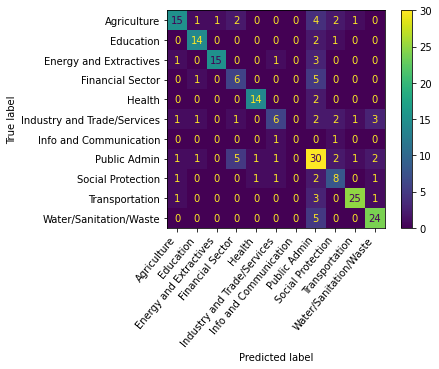

In [32]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

### LogisticRegression

In [33]:
lin = LogisticRegression(class_weight="balanced",C=1,penalty="elasticnet",l1_ratio=0.8,solver='saga',max_iter=5000, random_state=424)
logistic_grid = {
    "C": [0.1, 0.2, 0.5, 0.75, 1]
}
logistic_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('logistic',GridSearchCV(estimator=lin,param_grid=logistic_grid,scoring=make_scorer(accuracy_score),n_jobs=4))
])
logistic_pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logistic',
                 GridSearchCV(estimator=LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           l1_ratio=0.8,
                                                           max_iter=5000,
                                                           penalty='elasticnet',
                                                           random_state=424,
                                                           solver='saga'),
                              n_jobs=4,
                              param_grid={'C': [0.1, 0.2, 0.5, 0.75, 1]},
                              scoring=make_scorer(accuracy_score)))])

In [34]:
logistic_pipe['logistic'].best_params_

{'C': 0.2}

In [35]:
y_train_pred = logistic_pipe.predict(X_train)
log_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = logistic_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test,y_test_pred)
log_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
# log_top2_test_acc = top_k_accuracy_score(y_test,logistic_pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(log_train_acc,3))
print("Test Accuracy:", np.round(log_test_acc,3))
# print("Top 2 Test Accuracy:", np.round(log_top2_test_acc,3))

Train Accuracy: 0.654
Test Accuracy: 0.648


### Support Vector Machine

In [36]:
svm = SVC(max_iter=5000,probability=True,class_weight="balanced",C=2,random_state=1212)
svm_grid = {
    "C": [0.5, 1, 2, 5]
}
pipe = Pipeline([('scale',StandardScaler()),('svm',GridSearchCV(estimator=svm,param_grid=svm_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('svm',
                 GridSearchCV(estimator=SVC(C=2, class_weight='balanced',
                                            max_iter=5000, probability=True,
                                            random_state=1212),
                              n_jobs=4, param_grid={'C': [0.5, 1, 2, 5]},
                              scoring=make_scorer(accuracy_score)))])

In [37]:
y_train_pred = pipe.predict(X_train)
svm_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = pipe.predict(X_test)
svm_test_acc = accuracy_score(y_test,y_test_pred)
svm_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
# svm_top2_test_acc = top_k_accuracy_score(y_test,pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(svm_train_acc,3))
print("Test Accuracy:", np.round(svm_test_acc,3))
# print("Top 2 Test Accuracy:", np.round(svm_top2_test_acc,3))

Train Accuracy: 0.744
Test Accuracy: 0.683


### neural_network.MLPClassifier

In [38]:
mlp_est = MLPClassifier(hidden_layer_sizes=(32,16),max_iter=200,random_state=52234)
mlp_grid = {
    "hidden_layer_sizes": [(32, 16), (32, 32)],
    "max_iter": [200, 300, 400]
}
mlp = Pipeline([('scale', StandardScaler()),('mlp',GridSearchCV(estimator=mlp_est,param_grid=mlp_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
mlp.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scale', StandardScaler()),
                ('mlp',
                 GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(32,
                                                                          16),
                                                      random_state=52234),
                              n_jobs=4,
                              param_grid={'hidden_layer_sizes': [(32, 16),
                                                                 (32, 32)],
                                          'max_iter': [200, 300, 400]},
                              scoring=make_scorer(accuracy_score)))])

In [39]:
y_train_pred = mlp.predict(X_train)
mlp_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = mlp.predict(X_test)
mlp_test_acc = accuracy_score(y_test,y_test_pred)
mlp_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
# mlp_top2_test_acc = top_k_accuracy_score(y_test,mlp.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(mlp_train_acc,3))
print("Test Accuracy:", np.round(mlp_test_acc,3))
# print("Top 2 Test Accuracy:", np.round(mlp_top2_test_acc,3))

Train Accuracy: 0.781
Test Accuracy: 0.687


### VotingClassifier

In [40]:
ens = VotingClassifier([
    ('rf',rf),
    ('logistic',logistic_pipe),
    ('svm',pipe),
    ('mlp',mlp)
],voting='soft')#,weights=[0.4,0.2,0.2,0.2])
ens.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                                            max_depth=7,
                                                                            n_estimators=200,
                                                                            random_state=4252),
                                           n_jobs=4,
                                           param_grid={'ccp_alpha': [0, 0.001,
                                                                     0.002,
                                                                     0.005],
                                                       'max_depth': [6, 7, 8],
                                                       'n_estimators': [200,
                                                                        300,
                                                                  

In [41]:
y_train_pred = ens.predict(X_train)
ens_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = ens.predict(X_test)
ens_test_acc = accuracy_score(y_test,y_test_pred)
ens_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
# ens_top2_test_acc = top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(ens_train_acc,3))
print("Test Accuracy:", np.round(ens_test_acc,3))
# print("Top 2 Test Accuracy:", np.round(ens_top2_test_acc,3))

Train Accuracy: 0.794
Test Accuracy: 0.709
